In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as pc
import seaborn as sns
import scipy.stats as stats


In [2]:
kegg_pathway = pd.read_excel('KEGG_Pathway/KEGG_PathwayKO(pathway).xlsx')
kegg_pathway = kegg_pathway.replace(np.nan, '')
pathwayname = kegg_pathway.columns[1:].tolist()

In [3]:
dict_pathwaysize={}
for i in range(len(pathwayname)):
    pathwaysize = len(kegg_pathway[pathwayname[i]].replace(r'^\s*$', np.nan, regex=True).dropna())
    dict_pathwaysize1={pathwayname[i]:[pathwaysize]}
    dict_pathwaysize.update(dict_pathwaysize1)
pathwaysizePD=pd.DataFrame(dict_pathwaysize)

In [ ]:
communities_namelist1 = ['Human_cheek', 'Human_forehead', 'Human_nose', 'Marine', 'Mouse', 'Pig','3_countries_combined']
communities_namelist2 = ['Human_cheek_BiDgenes', 'Human_forehead_BiDgenes', 'Human_nose_BiDgenes', 'Marine_BiDgenes', 'Mouse_BiDgenes', 'Pig_BiDgenes','3_countries_combined_BiDgenes']
communities_namelist3 = ['Cheek', 'Forehead', 'Nose', 'Marine', 'Mouse gut', 'Pig gut', 'Human gut']
matrix1 = np.zeros((len(communities_namelist2), len(pathwayname)))
matrix2 = np.zeros((len(communities_namelist2), len(pathwayname)))
for i in range(len(communities_namelist2)):
    all_genes = pd.read_csv('genes normalization/'+communities_namelist1[i],sep='\t').iloc[:,0].tolist()
    all_bimodalgenes = pd.read_csv('bimodal genes/'+communities_namelist2[i],sep='\t').iloc[:,0].tolist()
    
    for j in range(len(pathwayname)):
        bimodalgenes_in_pathway = [gene for gene in kegg_pathway[pathwayname[j]] if gene in all_bimodalgenes]
        genes_in_pathway = [gene for gene in kegg_pathway[pathwayname[j]] if gene in all_genes]

        def hypergeometric_test(N, K, y, x):
            #Calculate the p-value of the hypergeometric distribution
            p_value = stats.hypergeom.sf(x-1, N, K, y)
            return p_value
        # Parameters
        N = len(all_genes)  # Total number of genes 
        K = len(all_bimodalgenes)    # Number of bimodal genes
        y = len(genes_in_pathway)   # Number of genes in the pathway
        x = len(bimodalgenes_in_pathway)     # Number of bimodal genes in the pathway
        # Calculate the p-value
        p_value = hypergeometric_test(N, K, y, x)
        matrix2[i,j] = p_value
        sigma = len(bimodalgenes_in_pathway)/((len(genes_in_pathway)*len(all_bimodalgenes))/len(all_genes))
        if sigma==0:
            matrix1[i,j] = sigma
        else:
            matrix1[i,j] = np.log(sigma)
sigmaPD = pd.DataFrame(matrix1,index=communities_namelist3,columns=pathwayname)
p_valuePD = pd.DataFrame(matrix2,index=communities_namelist3,columns=pathwayname)
sigmaPD.to_csv('fig/enrichment in pathway.csv')
p_valuePD.to_csv('fig/p_value in pathway.csv')


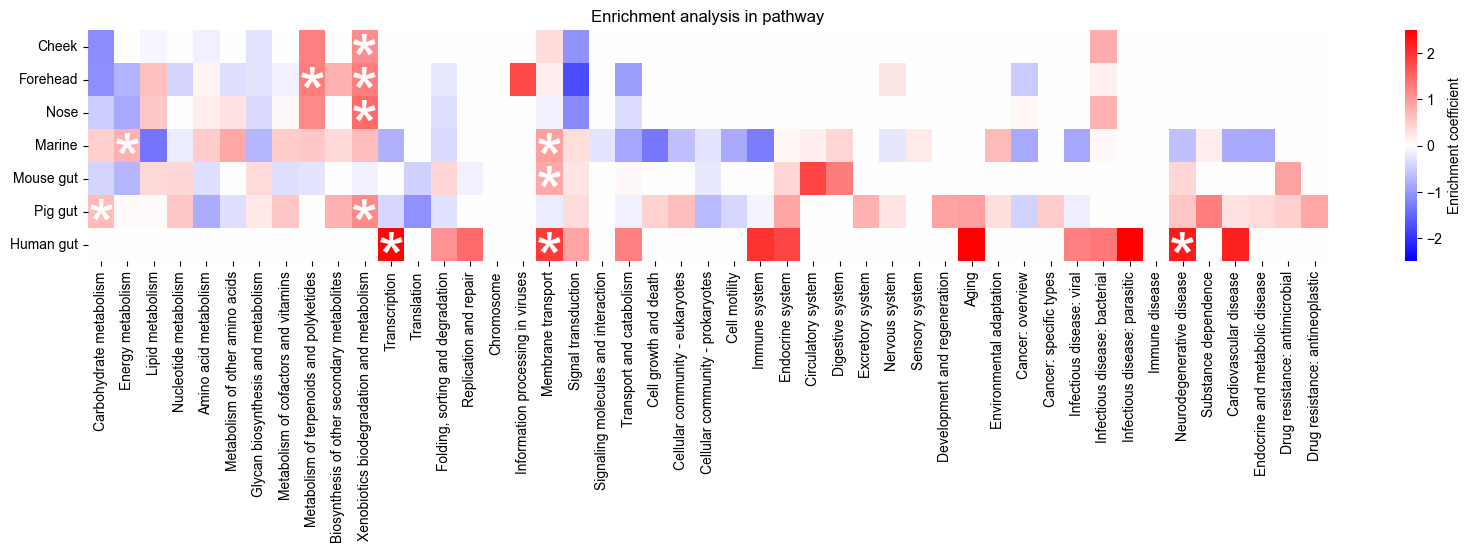

In [7]:
fig=plt.figure(figsize=(20,3))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
ax=fig.add_subplot(111)  
sns.heatmap(sigmaPD, cbar_kws={'label': 'Enrichment coefficient'}, vmin=-2.5, vmax=2.5, center=0,cmap="bwr") 

x_labels = pathwayname
for i in range(p_valuePD.shape[0]):
    for j in range(p_valuePD.shape[1]):
        if p_valuePD.iloc[i, j] < 0.05:
            ax.text(j+0.5, i+1.1, '*', ha='center', va='center', color='white', fontsize=50)
plt.title('Enrichment analysis in pathway')  
fig.savefig('fig/enrichment analysis in pathway.pdf',bbox_inches='tight')